In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
%matplotlib inline

In [2]:
data = pd.read_csv("text_data.csv")
data.head(24)

,locale,i_name,example
0,en,greetings,hi
1,en,greetings,hello
2,en,greetings,hey
3,en,order,I am hungry
4,en,order,I'd like a pizza
5,en,order,I want to order a pizza
6,en,order,I want to order a large pizza
7,en,order,Can I get a pizza margherita small please
8,en,order,za
9,en,order,order


In [3]:
data = data.sample(frac=1)
data

,locale,i_name,example
22,en,reset,delete the inputs
9,en,order,order
2,en,greetings,hey
6,en,order,I want to order a large pizza
14,en,exit,get me out of here
18,en,order,no
20,en,reset,begin
16,en,exit,cancel
0,en,greetings,hi
1,en,greetings,hello


In [4]:
data["i_name"].value_counts()

order        9
exit         4
reset        4
help         4
greetings    3
Name: i_name, dtype: int64

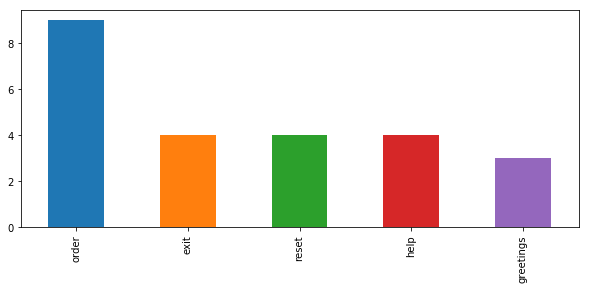

In [5]:
i_name_tags = ['greetings', 'order', 'help', 'exit', 'reset']
plt.figure(figsize=(10,4))
data.i_name.value_counts().plot(kind='bar');

In [6]:
from sklearn.model_selection import train_test_split
train_size = int(len(data) * .8)

In [7]:
X_train = data['example'][:train_size]
y_train = data['i_name'][:train_size]

#train labels
labels_train = data['i_name'][:train_size]

#test features
X_test = data['example'][train_size:]
y_test = data['i_name'][train_size:]

#test labels
labels_test = data['i_name'][train_size:]

In [8]:
print(len(X_train), len(X_test))
print('----------------------------')
print(y_test.shape)

19 5
----------------------------
(5,)


In [9]:
from tensorflow import keras
layers = keras.layers

In [10]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, decode_error="ignore")
# vectorizer.fit(X_train)
vocab_size = 1 #hyperparameter experiment
tokenize = keras.preprocessing.text.Tokenizer(num_words=vocab_size, char_level=False)
tokenize.fit_on_texts(X_train) #only fit the train


In [11]:
# X_train_vectorized = vectorizer.transform(X_train)
# print(X_train_vectorized)

# wide feature 1: sparse bag of words (bow) vocab_size_vector
X_bow_train = tokenize.texts_to_matrix(X_train)
X_bow_test = tokenize.texts_to_matrix(X_test)
# X_bow_train
X_bow_test

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [12]:
y_test.shape

(5,)

In [13]:
# wide feature 2: one-hot vector of variety categories
from sklearn.preprocessing import LabelEncoder
# Using sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
print(y_test)
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
num_class = np.max(y_train) + 1

# Converting labels to one-hot
y_train = keras.utils.to_categorical(y_train, num_class)
y_test = keras.utils.to_categorical(y_test, num_class)

21    reset
5     order
4     order
13     help
11     help
Name: i_name, dtype: object


In [14]:
bow_inputs = layers.Input(shape=(vocab_size))
y_inputs = layers.Input(shape=(num_class,))
merged_layer = layers.concatenate([bow_inputs, y_inputs])
merged_layer = layers.Dense(256, activation='relu')(merged_layer)
predictions = layers.Dense(1)(merged_layer)
wide_model = keras.Model(inputs=[bow_inputs, y_inputs], outputs=predictions)

In [15]:
bow_inputs

<tf.Tensor 'input_1:0' shape=(None, 1) dtype=float32>

In [16]:
wide_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
print(wide_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 6)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          1792        concatenate[0][0]            

In [17]:

train_embed = tokenize.texts_to_sequences(X_train)
test_embed = tokenize.texts_to_sequences(X_test)

max_seq_length = 50
train_embed = keras.preprocessing.sequence.pad_sequences(
train_embed, maxlen = max_seq_length, padding="post")
test_embed = keras.preprocessing.sequence.pad_sequences(
test_embed, maxlen = max_seq_length, padding="post")

In [18]:
deep_inputs = layers.Input(shape=(max_seq_length,))
embedding = layers.Embedding(vocab_size, 8, input_length=max_seq_length)(deep_inputs)
embedding = layers.Flatten()(embedding)
embed_out = layers.Flatten()(embedding)
deep_model = keras.Model(inputs=deep_inputs, outputs=embed_out)
print(deep_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 8)             8         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
deep_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [20]:
merged_out = layers.concatenate([wide_model.output, deep_model.output])
merger_out = layers.Dense(1)(merged_out)
combined_model = keras.Model(wide_model.input + [deep_model.input], merged_out)
print(combined_model.summary())

combined_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 6)            0           input_1[0][0]                    
                                                                 input_2[0][0]              

In [21]:
# Run training
combined_model.fit([X_train] + [y_train] + [train_embed], labels_test, epochs=10, batch_size=128)

ValueError: Input arrays should have the same number of samples as target arrays. Found 19 input samples and 5 target samples.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
cls = MultinomialNB()
# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(X_train), y_train)
 
from sklearn.metrics import classification_report, accuracy_score
 
y_pred = cls.predict(vectorizer.transform(X_test))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
 
# start with the classic
# with either pure counts or tfidf features
sgd = Pipeline([
        ("count vectorizer", CountVectorizer(stop_words="english", max_features=3000)),
        ("sgd", SGDClassifier(loss="modified_huber"))
    ])
sgd_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=3000)),
        ("sgd", SGDClassifier(loss="modified_huber"))
    ])
 
svc = Pipeline([
        ("count_vectorizer", CountVectorizer(stop_words="english", max_features=3000)),
        ("linear svc", SVC(kernel="linear"))
    ])
svc_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=3000)),
        ("linear svc", SVC(kernel="linear"))
    ])
   
all_models = [
    ("sgd", sgd),
    ("sgd_tfidf", sgd_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ]
 
unsorted_scores = [(name, cross_val_score(model, X_train, y_train, cv=2).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])
print(scores)  

In [ ]:
model = svc_tfidf
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

#%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))